# DS5559 Naive Bayes Wine Reviews v5 FINAL

## Synopsis

We attempt a Naive Bayes classifier for the sentiment of a corpus of wine reviews. We use the score of the review as our sentiment value, assuming that a bad review will have negative sentiment and a good review will have positive sentiment.

## Configuration

In [1]:
src_file = 'winereviews.csv'

# Set Hyperparameters
class Params():
    qntile_P = .9
    qntile_N = .1
    n_sets = 4
    smooth_alpha = .1
    binary_mode = True
params = Params()

## Libraries

In [2]:
import pandas as pd
import numpy as np
from numpy import log2 as log
from numpy import exp2 as exp
from numpy.random import randint
import textman as tx

## Pragmas

In [3]:
%matplotlib inline

# Process

## PREPARATION

### Import wine reviews

In [4]:
docs = pd.read_csv('winereviews.csv', index_col='doc_id')

In [5]:
docs.head()

,doc_content,points
doc_id,,
0,"Aromas include tropical fruit, broom, brimston...",87
1,"This is ripe and fruity, a wine that is smooth...",87
2,"Tart and snappy, the flavors of lime flesh and...",87
3,"Pineapple rind, lemon pith and orange blossom ...",87
4,"Much like the regular bottling from 2012, this...",87


### Convert points to labels

#### Keep only reviews with high and low ratings

In [6]:
bound_P = int(docs['points'].quantile(params.qntile_P))
bound_N = int(docs['points'].quantile(params.qntile_N))
docs = docs[(docs.points <= bound_N) | (docs.points >= bound_P)]

In [7]:
docs.sample(5)

,doc_content,points
doc_id,,
18327,"Dark, deep purple in color, this Petite grown ...",83
98671,The cool vintage took its toll on this Pinot N...,82
44237,"Flashy and delicious, this just blows your min...",93
69194,There's a sweet fruit and pastry quality to th...,94
23969,Here's an outstanding Chianti Classico made fr...,94


#### Assign labels for high and low

In [8]:
docs.loc[docs['points'] >= bound_P, 'doc_label'] = 'P'
docs.loc[docs['points'] <= bound_N, 'doc_label'] = 'N'

In [9]:
docs.head()

,doc_content,points,doc_label
doc_id,,,
336,"Gritty, heavily roasted aromas of peanuts and ...",83,N
337,"An easy and inviting selection, there's a ment...",83,N
338,The wine is earthy and somewhat rustic. There ...,82,N
339,"Red in color, with berry and apple aromas, thi...",82,N
340,"The nose is muted, despite the slight spritz o...",82,N


In [10]:
docs = docs.drop('points', 1)

In [11]:
docs.head()

,doc_content,doc_label
doc_id,,
336,"Gritty, heavily roasted aromas of peanuts and ...",N
337,"An easy and inviting selection, there's a ment...",N
338,The wine is earthy and somewhat rustic. There ...,N
339,"Red in color, with berry and apple aromas, thi...",N
340,"The nose is muted, despite the slight spritz o...",N


### Divide docs into train and test sets

#### Assign random numbers to docs

In [12]:
docs['set'] = randint(0,params.n_sets, len(docs.index))

In [13]:
docs.head()

,doc_content,doc_label,set
doc_id,,,
336,"Gritty, heavily roasted aromas of peanuts and ...",N,2
337,"An easy and inviting selection, there's a ment...",N,2
338,The wine is earthy and somewhat rustic. There ...,N,2
339,"Red in color, with berry and apple aromas, thi...",N,0
340,"The nose is muted, despite the slight spritz o...",N,1


#### Split docs by assigned number 

In [14]:
training_docs = docs[docs.set != 0].copy()
testing_docs = docs[docs.set == 0].copy()
del(docs)

In [15]:
training_docs = training_docs.drop('set', 1)
testing_docs = testing_docs.drop('set', 1)

In [16]:
round(len(training_docs) / len(testing_docs), 2)

2.97

### Convert docs to tokens

In [17]:
training_tokens, vocab = tx.create_tokens_and_vocab(training_docs, src_col='doc_content')
testing_tokens, _ = tx.create_tokens_and_vocab(testing_docs, src_col='doc_content')

In [18]:
training_tokens.head()

token term_str  term_id
doc_id sent_id token_id                           
336    0       0          Gritty   gritty     6502
               1         heavily  heavily     6765
               2         roasted  roasted    11773
               3          aromas   aromas     1011
               5         peanuts  peanuts    10171

### Apply training vocab to testing -- CRUCIAL

In [19]:
testing_tokens['term_id'] = testing_tokens.term_str.map(vocab.reset_index().set_index('term_str').term_id)
testing_tokens = testing_tokens.dropna()
testing_tokens['term_id'] = testing_tokens['term_id'].astype('int')

In [20]:
testing_tokens.head()

token term_str  term_id
doc_id sent_id token_id                          
339    0       0            Red      red    11344
               2          color    color     3122
               4          berry    berry     1565
               6          apple    apple      915
               7         aromas   aromas     1011

#### Simplify tokens table 

In [21]:
training_tokens = training_tokens.reset_index()[['doc_id','term_id']]
testing_tokens = testing_tokens.reset_index()[['doc_id','term_id']]

In [22]:
if params.binary_mode:
    training_tokens = training_tokens.drop_duplicates()
    testing_tokens = testing_tokens.drop_duplicates()

In [23]:
training_tokens.head()

,doc_id,term_id
0,336,6502
1,336,6765
2,336,11773
3,336,1011
4,336,10171


### Transfer doc labels and splits to tokens -- CRUCIAL

In [24]:
training_tokens = training_tokens.join(training_docs[['doc_label']], on='doc_id', how='inner')
# testing_tokens = testing_tokens.join(testing_docs[['doc_label']], on='doc_id', how='left')

In [25]:
training_tokens.head()

,doc_id,term_id,doc_label
0,336,6502,N
1,336,6765,N
2,336,11773,N
3,336,1011,N
4,336,10171,N


## TRAINING

### Estimate class priors $p(c)$

$$
\hat{P}(c) = \dfrac{N_{c}}{N_{d}}
$$

In [26]:
Nc = training_docs['doc_label'].value_counts()
Nd = training_docs.shape[0]
class_priors = Nc / Nd

In [27]:
np.round(class_priors, 2)

P    0.5
N    0.5
Name: doc_label, dtype: float64

Since these are literally $50/50$, we really don't need them.

#### Convert priors to logs

In [28]:
class_priors_log = log(class_priors)

In [29]:
np.round(class_priors_log)

P   -1.0
N   -1.0
Name: doc_label, dtype: float64

### Estimate likelihoods $p(w|c)$

$$
\hat{P}(w_i|c) = \dfrac{count(w_i,c)}{\sum_{w \in V} count(w,c)}
$$

$$
\hat{P}(w_i|c) = \dfrac{count(w_i,c)+1}{\sum_{w \in V} (count(w,c)+1)} = \dfrac{count(w_i,c)+1}{(\sum_{w \in V} count(w,c))+|V|} 
$$



Now we compute the probability of a token given the label. This will in effect product two language models, one for each label. Key idea = **the likelihoods are language models** (see Pearl for interpretation of likelihoods).

In [30]:
class_likelihoods = training_tokens.groupby(['term_id', 'doc_label']).doc_label.count()\
    .unstack().fillna(0)

In [31]:
class_likelihoods = class_likelihoods + params.smooth_alpha
class_likelihoods = class_likelihoods / class_likelihoods.sum()

In [32]:
class_likelihoods.head()

doc_label,N,P
term_id,,
343,6.125473e-07,0.000011
345,6.125473e-07,0.000011
346,6.125473e-07,0.000011
348,6.125473e-07,0.000011
351,6.125473e-07,0.000015


#### Convert likelihoods to logs

In [33]:
class_likelihoods_log = log(class_likelihoods)

In [34]:
class_likelihoods_log.head()

doc_label,N,P
term_id,,
343,-20.638675,-16.420654
345,-20.638675,-16.420654
346,-20.638675,-16.420654
348,-20.638675,-16.420654
351,-20.638675,-16.017298


## TESTING

### Add likelihood columns to test tokens table

This is effectively how we apply our model to the test set.

In [35]:
testing_tokens.head()

,doc_id,term_id
0,339,11344
1,339,3122
2,339,1565
3,339,915
4,339,1011


In [36]:
testing_tokens = testing_tokens\
    .join(class_likelihoods_log[['P','N']], on='term_id', how='inner')

In [37]:
testing_tokens.sample(5)

,doc_id,term_id,P,N
46462,40326,3018,-9.173032,-10.791618
115952,103128,3579,-13.240424,-12.850773
81637,73990,12872,-9.151753,-9.746133
21201,17291,7356,-9.852759,-11.292162
137163,121887,1655,-7.966653,-8.505854


### Compute posteriors $p(c|w)$

$$
c_{NB} = \arg\max \log{P(c)} + \sum_{id=1}^{id_{max}} \log{P(token_{id}|c)}
$$




In [38]:
testing_docs['prediction'] = testing_tokens.groupby('doc_id')\
    .apply(lambda x: x[['P','N']].sum())\
    .apply(lambda x: x + class_priors_log, 1)\
    .idxmax(1)

In [39]:
testing_docs.head()

,doc_content,doc_label,prediction
doc_id,,,
339,"Red in color, with berry and apple aromas, thi...",N,N
341,"Plummy and hinting at black cherry, this wine ...",N,N
347,"Dusty, saffron-spiced earthiness is juxtaposed...",P,P
350,"After a few minutes in the glass, this stunnin...",P,P
352,Citrus-kissed saltiness lies at the core of th...,P,P


## EVALUATION

In [40]:
testing_docs['result'] = testing_docs.doc_label == testing_docs.prediction

In [88]:
testing_docs.head()

,doc_content,doc_label,prediction,result
doc_id,,,,
339,"Red in color, with berry and apple aromas, thi...",N,N,True
341,"Plummy and hinting at black cherry, this wine ...",N,N,True
347,"Dusty, saffron-spiced earthiness is juxtaposed...",P,P,True
350,"After a few minutes in the glass, this stunnin...",P,P,True
352,Citrus-kissed saltiness lies at the core of th...,P,P,True


### Show raw T & F count

In [41]:
raw = testing_docs.result.value_counts()

In [42]:
raw

True     5892
False     227
Name: result, dtype: int64

In [43]:
raw[True] / raw[False]

25.955947136563875

### Create confusion matrix

In [44]:
CM = testing_docs.reset_index().groupby(['prediction','doc_label']).doc_id.count().unstack().fillna(0)

In [45]:
CM.columns.name = 'actual'

In [46]:
CM

actual,N,P
prediction,,
N,2890,54
P,173,3002


In [47]:
def get_results(CM):

    class Results():
        
        TP = CM.iloc[0,0] # hits
        FP = CM.iloc[0,1] # Type I errors; false alarms
        TN = CM.iloc[1,1] # correct rejections
        FN = CM.iloc[1,0] # Type  II errors; misses
        T = TP + TN
        F = FP + FN
        ALL =  T + F
        ACC = T / ALL # Accuracy
        TPR = TP / (TP + FN) # Recall, Sensitivity
        TNR = TN / (TN + FP) # Specificity
        PPV = TP / (TP + FP)  # Precision; Positive predictive value 
        BA = (TNR + TPR) / 2 # Balanced Accuracy
        F1 = (2 *  TP) / (2 * TP + FP + FN) # F-score where F =  1

        assert ALL == CM.sum().sum()
                
        def show_results(self):
            print('TPR:', round(self.TPR, 2), '(sensitivity)')
            print('TNR:', round(self.TNR, 2), '(specificity)')
            print('F1: ', round(self.F1, 2), '<-- GRADE')
            print('-'*9)
            print('PPV:', round(self.PPV, 2),  '(precision)')
            print('ACC:', round(self.ACC, 2), '(accuracy)')
            
    return Results()

In [48]:
R = get_results(CM)

In [49]:
R.show_results()

TPR: 0.94 (sensitivity)
TNR: 0.98 (specificity)
F1:  0.96 <-- GRADE
---------
PPV: 0.98 (precision)
ACC: 0.96 (accuracy)


## EXPLORE

### Likelihoods as Sentiment Lexicon 

#### We make up a way to compute sentiment valence and polarity

In [50]:
sentilex = (np.sign(class_likelihoods['P'] - class_likelihoods['N'])).to_frame()\
    .rename(columns={0:'polarity'})
sentilex['valence'] = (class_likelihoods['P'] - class_likelihoods['N']) * 1000
sentilex['term_str'] = vocab.term_str
sentilex = sentilex.set_index('term_str')

#### Ratio of positive to negative terms

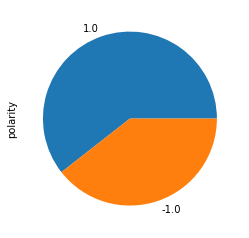

In [51]:
sentilex.polarity.value_counts().plot(kind='pie')

#### Top positive words

In [52]:
sentilex.sort_values('valence', ascending=False).head(10)

,polarity,valence
term_str,,
black,1.0,6.161197
rich,1.0,5.903866
drink,1.0,4.920940
years,1.0,4.776789
tannins,1.0,4.239310
ripe,1.0,3.875569
dark,1.0,3.729353
concentrated,1.0,3.726220
vineyard,1.0,3.591439


#### Top negative words

In [53]:
sentilex.sort_values('valence', ascending=True).head(10)

,polarity,valence
term_str,,
flavors,-1.0,-18.353812
aromas,-1.0,-8.813147
finish,-1.0,-8.741092
sweet,-1.0,-6.588402
simple,-1.0,-5.981134
soft,-1.0,-5.536443
green,-1.0,-4.924450
light,-1.0,-4.778476
dry,-1.0,-4.033767


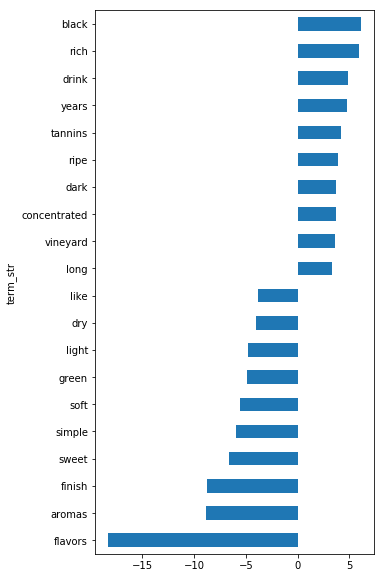

In [54]:
wpos = sentilex.valence.sort_values(ascending=False).head(10)
wneg = sentilex.valence.sort_values(ascending=False).tail(10)
pd.concat([wpos,wneg]).sort_values().plot.barh(figsize=(5,10))

### Expected Mutual Information

![](emi.png)

In [55]:
training_tokens.head()

,doc_id,term_id,doc_label
0,336,6502,N
1,336,6765,N
2,336,11773,N
3,336,1011,N
4,336,10171,N


In [56]:
p_c = class_priors.to_frame()
p_c.columns = ['p']
p_c.index.name = 'doc_label'

In [57]:
p_c

,p
doc_label,
P,0.502892
N,0.497108


In [58]:
p_w = (training_tokens.term_id.value_counts() / training_tokens.shape[0]).to_frame()
p_w.columns = ['p']
p_w.index.name = 'term_id'
p_w['term_str'] = vocab.term_str

In [59]:
p_w.sort_values('p', ascending=False).head()

,p,term_str
term_id,,
15641,0.021412,wine
5617,0.019586,flavors
5954,0.013338,fruit
10002,0.011246,palate
1011,0.010829,aromas


In [75]:
p_cw = training_tokens.groupby(['term_id','doc_label']).count() / training_tokens.shape[0]
p_cw.columns = ['p']

In [77]:
p_cw.head()

,,p
term_id,doc_label,
343,P,0.000007
345,P,0.000007
346,P,0.000007
348,P,0.000007
351,P,0.000009


In [83]:
EMI = training_tokens.join(p_cw, on=['term_id','doc_label'], how='left').rename(columns={'p':'p_cw'})
EMI = EMI.join(p_w['p'], on='term_id', how='left').rename(columns={'p':'p_w'})
EMI = EMI.join(p_c, on='doc_label', how='left').rename(columns={'p':'p_c'})
EMI = EMI.join(vocab['term_str'], on='term_id', how='left')
EMI['emi'] = EMI.p_cw * log(EMI.p_cw/(EMI.p_c * EMI.p_w))
EMI = EMI[['doc_label','term_id','term_str','emi']].drop_duplicates().set_index(['doc_label','term_id'])

In [84]:
VN = EMI.loc['N'].sort_values('emi', ascending=False).head(100)

In [85]:
VP = EMI.loc['P'].sort_values('emi', ascending=False).head(100)

In [86]:
VP.head()

,term_str,emi
term_id,,
1652,black,0.004301
4496,drink,0.004014
11678,rich,0.003834
13957,tannins,0.003580
11724,ripe,0.003065


In [87]:
VN.head()

,term_str,emi
term_id,,
5617,flavors,0.003040
12692,simple,0.002249
13812,sweet,0.001463
6453,green,0.001375
12928,soft,0.001296
